# dotdata ML task

## Data Science Use Case: prediction of tips for taxi drivers

### Data
	1. NYC taxi trip history data from 2015/01 – 2015/12
	2. Daily weather data from 2015/01 – 2015/12
	3. Public holiday data for the year of 2015

## Problem
Build an ML model to predict whether each trip has over 20% tip rate or not.

### Expected outputs

	1. Please submit the code you developed to build predictive model(s) as Jupyter notebook(s) on Python3 kernel.
	2. Please summarize the key conclusion of your analysis. This report should include the following:
		a. The most significant features that affect each trip’s tip percentage.
		b. The performance of your predictive model(s), and suggest what additional dataset you’d like to include to improve the performance of your models.

### Note
	1.  Please assume the client wants to get the model with high prediction accuracy.
	2.  Please assume the code would be reviewed by your team members, and be further developed.

In [4]:
import numpy as np
import pandas as pd
import mysql.connector
import json
import math
import datetime
import argparse
import matplotlib.pyplot as plt
from operator import add, truediv
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from scipy.stats.stats import pearsonr



### MYSQL CONNECTION

In [5]:
port = 3306
username = "rhombus"
password = "Rhombus_2019z"
end_point = "afwic.c9fkygyhkkab.us-gov-west-1.rds.amazonaws.com"
afwic = mysql.connector.connect(user=username, password=password, host=end_point, port=port)

username = "rhombus"
password = "rhombuspower"
end_point = "quantum.c9fkygyhkkab.us-gov-west-1.rds.amazonaws.com"
quantum = mysql.connector.connect(user=username, password=password, host=end_point, port=port)


### READ LIMS_EV AVAILABILITY (FY2000 -)

In [6]:
df_availability = pd.read_sql(''' SELECT * FROM LIMS_EV.AFKCA_MCH_PSH_AVAILABILITY ''',afwic)
df_availability.head()

,AFKCA_TYPEID,AFKCA_TYPE,AFKCAID,AFKCA,RULE_BASE,OPS,FISCAL_YEAR,MCH,PSH,AVAILABILITY
0,21,FIGHTERS,0178,A-10,PER_TAI,OPS,2000,956440,1360887,0.702806
1,21,FIGHTERS,0178,A-10,PER_TAI,OPS,2001,1315798,1907818,0.689687
2,21,FIGHTERS,0178,A-10,PER_TAI,OPS,2002,1392911,1862808,0.747748
3,21,FIGHTERS,0178,A-10,PER_TAI,OPS,2003,1274985,1767422,0.721381
4,21,FIGHTERS,0178,A-10,PER_TAI,OPS,2004,1292132,1790392,0.721703


### READ ABIDES BUDGET (FY2001-2023)

In [7]:
df_budget = pd.read_sql(''' SELECT * FROM PROGRAMMING_UI.DT_ABIDES_AFKCA ''',quantum)
df_budget.head()

,AFKCA_TYPEID,AFKCA_TYPE,AFKCAID,AFKCA,OPS,FY_START,FY_END,FORCES_TAI,FORCES_BUY,FORCES_DIV,FORCES_ATT,MANPOWER_SIZE,RDTE,PROCUREMENT,OM,MILPERS,MILCON,OTHER
0,01,ACS-EXPEDITIONARY,0471,EXPEDITIONARY-SS,ACS,2001,2023,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","1978,2251,2328,2286,2303,2322,2298,2154,3123,2...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,262,351,157,170,309,2967,2250,3213,198...","127618,146048,176602,179861,180990,166024,1747...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0"
1,01,ACS-EXPEDITIONARY,0873,EXPEDITIONARY-RGM,ACS,2001,2023,"18,18,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","22900,37961,51712,38178,38045,37581,38338,3401...","0,0,0,0,0,2637,0,0,0,0,0,0,0,0,0,0,26925,26222...","200011,232912,218733,55035,29037,39377,30735,1...","764840,1031766,1101276,377478,271934,259816,26...","638562,1645004,1485463,1936767,1993326,1854197...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9000,0,0,0,0,0","6502357,0,6065960,6180656,6191064,5949569,1199..."
2,01,ACS-EXPEDITIONARY,0874,EXPEDITIONARY-GPA,ACS,2001,2023,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","17501,18020,30966,30517,30638,30716,30391,2760...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,411,6138,12559,55527,76180,72065,37376,33461...","1055262,1174550,1897231,2351865,2362462,213951...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0"
3,01,ACS-EXPEDITIONARY,1008,EXPEDITIONARY-CS,ACS,2001,2023,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","18090,13583,13380,12979,12867,12835,12678,1042...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","4403,10047,8850,6495,5342,4495,4318,11934,4962...","233576,157675,181668,175873,177210,176658,1617...","347970,326222,362236,354826,372262,362016,3686...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0"
4,01,ACS-EXPEDITIONARY,1009,EXPEDITIONARY-NDO,ACS,2001,2023,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","3311,3935,5604,5395,5376,5427,5489,5028,5166,5...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,146,2843,3041,3862,13601,2366,1100,1321,...","202079,254456,413940,415862,413053,374042,3978...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0"


### READ AFKCA CONNECTIONS

In [8]:
df_afkca = pd.read_sql(''' SELECT * FROM PLANNING_UI_DEPLOY.LOOKUP_CONNECTION_AFKCA ''',quantum)
df_afkca.head()

,PANEL,PANEL_TITLE,AFKCA_TYPEID,AFKCA_TYPE,AFKCAID,AFKCA,RULE_BASE,OPS,CONNECTED_AFKCA_OPS,CONNECTED_AFKCA_ACS,CONNECTED_AFKCA_SSS
0,B,FM,16,CORPORATE MGT,1017,MGT HQ-ACS (P&T),PER_TOT,SSS,None,"{'AFKCA': {'EXPEDITIONARY-RGM', 'EXPEDITIONARY...","{'AFKCA': {'MGT HQ-ACS (P&T)', 'PROGRAM EVAL',..."
1,B,FM,01,ACS-EXPEDITIONARY,0873,EXPEDITIONARY-RGM,PER_TOT,ACS,"{'AFKCA': {'ELECTRONIC WARFARE', 'HH-60', 'SLC...","{'AFKCA': {'EXPEDITIONARY-RGM'}, 'RULE_BASE': ...","{'AFKCA': {'MGT HQ-ACS (P&T)', 'PROGRAM EVAL',..."
2,B,FM,03,ACS-POLICY,1235,PROGRAM EVAL,PER_TOT,SSS,"{'AFKCA': {'B-21'}, 'RULE_BASE': {'PER_TOT'}, ...","{'AFKCA': {'EXPEDITIONARY-RGM'}, 'RULE_BASE': ...","{'AFKCA': {'MGT HQ-ACS (P&T)', 'PROGRAM EVAL',..."
3,E,NUCLEAR DET OPS,01,ACS-EXPEDITIONARY,1009,EXPEDITIONARY-NDO,PER_TOT,ACS,"{'AFKCA': {'B-1', 'B-2', 'B-52', 'E-4', 'ARMS ...","{'AFKCA': {'EXPEDITIONARY-NDO', 'NC3', 'ALCM F...","{'AFKCA': {'MGT HQ-NDO', 'CCMD AGCY SPT-NDO', ..."
4,E,NUCLEAR DET OPS,07,BOMBERS,0001,B-1,PER_TAI,OPS,"{'AFKCA': {'B-1', 'B-2', 'B-52', 'E-4', 'ARMS ...","{'AFKCA': {'EXPEDITIONARY-NDO', 'NC3', 'ALCM F...","{'AFKCA': {'MGT HQ-NDO', 'CCMD AGCY SPT-NDO', ..."


### AFKCA OF INTERESTS

In [9]:
saveeq = {'A010A':'A-10','A010C':'A-10',
       'AC130H':'AC-130H/U','AC130J':'AC-130J','AC130U':'AC-130H/U','AC130W':'AC-130W',
       'B001B':'B-1','B002A':'B-2',
       'B052G':'B-52','B052H':'B-52','B052C':'B-52','B052D':'B-52','B052E':'B-52','B052F':'B-52',
       'C012A':'C-12','C012C':'C-12','C012D':'C-12','C012F':'C-12','C012J':'C-12',
       'C017A':'C-17',
       'C020A':'C-20','C020B':'C-20','C020C':'C-20','C020E':'C-20','C020H':'C-20','C020K':'C-20',
       'C021A':'C-21',
       'C032A':'C-32','C032B':'C-32',
       'C037A':'C-37','C037B':'C-37',
       'C040A':'C-40','C040B':'C-40','C040C':'C-40',
       'C130H':'C-130H','C130J':'C-130J',
       'CV022B':'CV-22',
       'E003A':'E-3','E003B':'E-3','E003C':'E-3','E003G':'E-3',
       'E004B':'E-4','E008A':'E-8','E008C':'E-8',
       'EC130E':'EC-130 CCALL','EC130H':'EC-130 CCALL','EC130J':'EC-130 CCALL',
       'F015C':'F-15CD','F015D':'F-15CD','F015E':'F-15E',
       'F016C':'F-16CD','F016D':'F-16CD',
       'F022A':'F-22',
       'F035A':'F-35A',
       'F117A':'F-117',
       'HC130J':'HC-130J',
       'HC130N':'HC-130N/P',
       'HC130P':'HC-130N/P',
       'HH060A':'HH-60','HH060G':'HH-60','HH060U':'HH-60',
       'KC010A':'KC-10',
       'KC135A':'KC-135','KC135D':'KC-135','KC135E':'KC-135','KC135R':'KC-135','KC135T':'KC-135','KC135Q':'KC-135',
       'LC130H':'C-130H',
       'MC012W':'MC-12',
       'MC130H':'MC-130H','MC130J':'MC-130J',
       'MQ001B':'MQ-1','MQ009A':'MQ-9',
       'OC135B':'ARMS CONTROL (OC-135B)',
       'RC026B':'RC-26',
       'RQ004A':'RQ-4','RQ004B':'RQ-4',
       'T001A':'T-1',
       'T006A':'T-6',
       'T038A':'T-38','T038C':'T-38',
       'TH001H':'TH-1','TH001F':'TH-1',
       'U002S':'U-2','TU002R':'U-2','U002R':'U-2',
       'UH001H':'UH-1N NDO','UH001N':'UH-1N NDO','UH001V':'UH-1N NDO','UH001F':'UH-1N NDO','UH001P':'UH-1N NDO',
       'VC025A':'VC-25A',
       'WC130J':'WC-130J',
       'WC135B':'WC-135','WC135C':'WC-135','WC135W':'WC-135'}
lut = pd.DataFrame.from_dict(saveeq,orient='index')
lut.columns = ['AFKCA']
lut.index.names = ['EQUIPMENT_DESIGNATOR']
lut.head()

,AFKCA
EQUIPMENT_DESIGNATOR,
A010A,A-10
A010C,A-10
AC130H,AC-130H/U
AC130J,AC-130J
AC130U,AC-130H/U


Hi Allen,

We would like you to work on a modeling problem set.

Here, i can provide a context. The AF wants to know how increasing/decreasing budget affects aircraft's availability (mission capable hours divided by possession hours). Assuming that zero money will result in zero availability, we would see that increasing money will bring better availability. Note that, in addition to direct operational money, there are indirect budget monies supporting aircraft operations. We would like to know the correlations between aircraft availability and direct/indirect budget, and their sensitivities and correlations. 

1) We have a time series of F-15CD availability (Mission Capable Hours / Possession Hours)
= MCH / PSH
2) We also have a times series of AF budget for F-15CD with a break down into Procurement, OM, MILPERS, MILCON, RDTE, and OTHER.
3) In addition, we know the AF budget for other AFKCAs (Agile combat support ACS afkca and Sustainment, Service and Support SSS afkca). 
4) We also know TAI (total aircraft inventory) for each AFKCA

We want to know how the AF budget affect F-15CD availability.
* use RidgeCV (regression)
* for each AFKCA, train availability = a function of MILPERS and OM 
* Ignore Procurement, MILCON, Other, RDTE for now
* each AFKCA also has a connection to ACS and SSS AFKCAs. Use their total budget. 
* remove training data points if TAI is zero 
* ingest zero availabilty if total budget is zero 
* get correlations between availability and other variables for each AFKCA 
* get sensitivity between availability and other variables for each AFKCA

I attached a jupyter notebook with database and connection information. 
Could you please start working on this (today is July-17) and provide some preliminary results by next Monday? We can sit down and talk more regarding this problem set. 

Sungho



 * each AFKCA also has a connection to ACS and SSS AFKCAs. Use their total budget. 

In [57]:
import ast
def extract_afkca(x):
    x = x.replace('{','[').replace('}',']')
    x = '{{{}}}'.format(x[1:-1])
    x = ast.literal_eval(x)['AFKCA']
    return x
def extract_afkcaid(x):
    x = x.replace('{','[').replace('}',']')
    x = '{{{}}}'.format(x[1:-1])
    x = ast.literal_eval(x)['AFKCAID']
    return x
df = pd.read_sql(''' SELECT * FROM PLANNING_UI_DEPLOY.LOOKUP_CONNECTION_AFKCA ''',quantum)
print(extract_afkca(df.CONNECTED_AFKCA_ACS[0]))
print(extract_afkcaid(df.CONNECTED_AFKCA_ACS[0]))

['EXPEDITIONARY-RGM', 'EXPEDITIONARY-ACS (P&T)', 'BASES (P&T)']
['0873', '1049', '0961']


In [58]:
connected_ACS = df_afkca[df_afkca.AFKCA == 'F-15CD'].CONNECTED_AFKCA_ACS.iloc[0]
connected_SSS = df_afkca[df_afkca.AFKCA == 'F-15CD'].CONNECTED_AFKCA_SSS.iloc[0]
print(extract_afkca(connected_ACS), extract_afkcaid(connected_ACS))
print(extract_afkca(connected_SSS), extract_afkcaid(connected_SSS))

['AIM-120', 'TACTICAL AIM MSLS', 'TACTICAL AGM MSLS', 'STAND-IN ATTACK WPN', 'EXPEDITIONARY-GPA', 'STAND-OFF ATTACK WPN', 'OTHER MUNITIONS GPA', 'AGM-114 HELLFIRE', 'ADV TARGET PODS', 'JDAM', 'JASSM', 'LRASM', 'SDB'] ['0345', '0353', '0990', '1223', '0874', '0352', '0371', '0666', '0779', '0832', '0924', '1104', '1191']
['TEST & EVALUATION', 'MGT HQ-AS', 'CCMD AGCY SPT-AS', 'AS (NA)', 'MISSION TRNG-AS', 'MISSION TRNG-GPA', 'T-38', 'MGT HQ-GPA', 'CCMD AGCY SPT-GPA', 'AIR OPS SQUADRON'] ['1063', '1085', '1209', '0506', '1075', '1077', '0110', '1016', '1194', '0505']


# Inflation adjustment

Extract 2001 to 2023 from 2018-pegged dollars

In [69]:
syr = 2001
eyr = 2023
dadj = pd.read_csv('DOLLAR_ADJ_sample.csv')
dadj_scale = dadj.loc[dadj.CALENDAR_YEAR.isin(range(syr,eyr+1))].SCALE_FACTOR_Y2018.values
dadj_scale

array([1.44, 1.42, 1.39, 1.36, 1.32, 1.27, 1.25, 1.19, 1.19, 1.16, 1.14,
       1.11, 1.09, 1.08, 1.08, 1.06, 1.04, 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  ])

2019-2023 should be less than one but are missing.  Extrapolating with linear model,

array([1.44      , 1.42      , 1.39      , 1.36      , 1.32      ,
       1.27      , 1.25      , 1.19      , 1.19      , 1.16      ,
       1.14      , 1.11      , 1.09      , 1.08      , 1.08      ,
       1.06      , 1.04      , 1.        , 0.95581699, 0.930172  ,
       0.904527  , 0.87888201, 0.85323701])

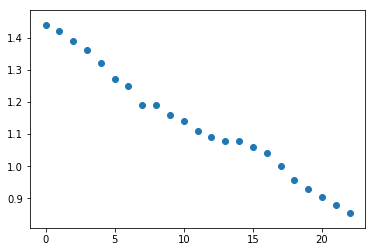

In [142]:
model=LinearRegression()
Y = dadj_scale[:-5]
X = np.array(range(len(Y)))
X=X.reshape(-1,1)
model.fit(X,Y)
X_predict=np.array(range(23))
X_predict = X_predict.reshape(-1,1)
Y_predict = model.predict(X_predict)
dadj_scale = np.array(list(dadj_scale[:-5]) + list(Y_predict[-5:]))
plt.scatter(range(len(dadj_scale)), dadj_scale)
dadj_scale

* Sungho noted that the inflation adjustment is already in the data

In [440]:
def extract_budget(afkca='F-15CD', kind='MILPERS'):
    def lmap(func, alist):
        return list(map(func, alist))
    return np.array(lmap(float, df_budget[df_budget['AFKCA'] == afkca].iloc[0][kind].split(',')))

milpers = extract_budget(afkca='F-15CD', kind='MILPERS')
om = extract_budget(afkca='F-15CD', kind='OM')
TAI = extract_budget('F-15CD', kind='FORCES_TAI')

# MILPERS/TAI, OM/TAI both increase intrinsically

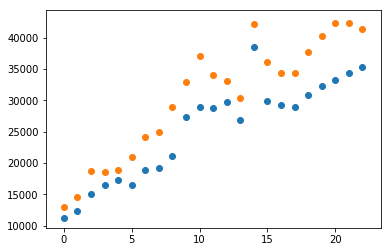

In [459]:
plt.scatter(range(len(milpers)), total_milpers/TAI)
plt.scatter(range(len(om)), total_om/TAI)

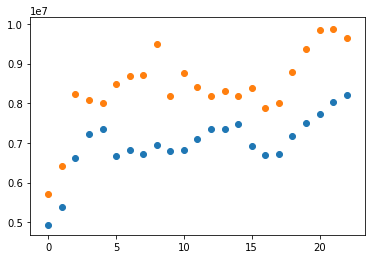

In [379]:
plt.scatter(range(len(total_milpers)), total_milpers)
plt.scatter(range(len(total_om)), total_om )

# simple min/max scaler

* map points function's lowest point to the horizontal axis
* scale the max point to 2, subtract 1
* output range: [-1,1]

In [266]:
def get_min_max(seq):
    min_ = min(seq)
    seq = seq-min_
    max_ = max(seq)
    seq = seq/max_
    return [(min_,max_),seq]

def get_deltas(seq):
    deltas = [] 
    i=0
    while i < len(seq)-1:
        deltas.append(seq[i+1]-seq[i])
        i+=1
    return np.array(deltas)

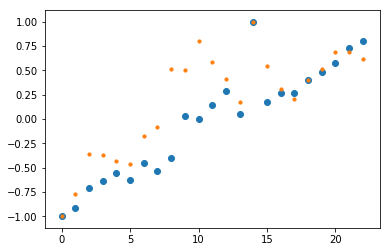

In [267]:
plt.scatter(range(23),get_min_max(milpers/TAI)[1])
plt.scatter(range(23), get_min_max(om/TAI)[1],s=10)

In [256]:
def get_deltas(seq):
    deltas = [] 
    i=0
    while i < len(seq)-1:
        deltas.append(seq[i+1]-seq[i])
        i+=1
    return np.array(deltas)

# fractional budget/TAI change from 2002-2018

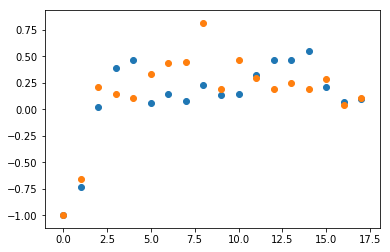

In [443]:
plt.scatter(range(18), get_min_max(total_milpers)[1][:-5])
plt.scatter(range(18), get_min_max(total_om)[1][:-5])

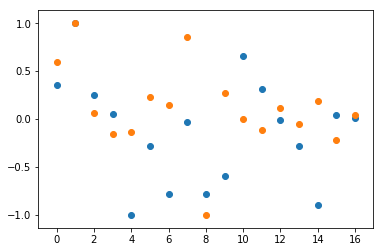

In [269]:
plt.scatter(range(17), get_min_max(get_deltas(milpers))[1][:-5])
plt.scatter(range(17), get_min_max(get_deltas(om))[1][:-5])

In [271]:
import ast
def extract_afkca(x):
    x = x.replace('{','[').replace('}',']')
    x = '{{{}}}'.format(x[1:-1])
    x = ast.literal_eval(x)['AFKCA']
    return x

connected_ACS = df_afkca[df_afkca.AFKCA == 'F-15CD'].CONNECTED_AFKCA_ACS.iloc[0]
connected_SSS = df_afkca[df_afkca.AFKCA == 'F-15CD'].CONNECTED_AFKCA_SSS.iloc[0]
print(extract_afkca(connected_ACS), extract_afkca(connected_SSS))

['AIM-120', 'TACTICAL AIM MSLS', 'TACTICAL AGM MSLS', 'STAND-IN ATTACK WPN', 'EXPEDITIONARY-GPA', 'STAND-OFF ATTACK WPN', 'OTHER MUNITIONS GPA', 'AGM-114 HELLFIRE', 'ADV TARGET PODS', 'JDAM', 'JASSM', 'LRASM', 'SDB'] ['TEST & EVALUATION', 'MGT HQ-AS', 'CCMD AGCY SPT-AS', 'AS (NA)', 'MISSION TRNG-AS', 'MISSION TRNG-GPA', 'T-38', 'MGT HQ-GPA', 'CCMD AGCY SPT-GPA', 'AIR OPS SQUADRON']


In [296]:
all_connections = extract_afkca(connected_ACS) + extract_afkca(connected_SSS)

def extract_budget(afkca='F-15CD', kind='MILPERS'):
    def lmap(func, alist):
        return list(map(func, alist))
    return np.array(lmap(float, df_budget[df_budget['AFKCA'] == afkca].iloc[0][kind].split(',')))

for afk in all_connections:
    print(afkca, extract_budget(afkca=afk, kind='MILPERS'), extract_budget(afkca=afk, kind='OM'))

AIR OPS SQUADRON [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [ 9943.  9790. 13826. 13885.  4654.  5690.  5851.  6548.  7169. 14377.
  8129.  7867.  7983.  8876. 10686. 15469. 13783. 13522. 16283. 14928.
 15274. 15784. 16353.]
AIR OPS SQUADRON [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [22445. 17860. 17019. 25266. 19649. 24008. 20331. 18469. 20034. 13366.
 14960. 23287. 15752. 19052. 20637. 25960. 23491. 22083. 25801. 27418.
 25891. 25596. 25885.]
AIR OPS SQUADRON [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [14096. 11538. 11339. 16141. 18115. 20354. 18066. 16699. 17326. 14064.
 15738. 16312. 13652. 13012. 14246. 16258. 15871. 13820. 15295. 14890.
 14642. 15239. 15365.]
AIR OPS SQUADRON [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
AIR OPS SQUADRON [1055262. 1174550. 1897231. 2351865. 2362462. 2139514. 2244041. 2

# Extract total connected budgets

In [318]:
connected_ACS = df_afkca[df_afkca.AFKCA == 'F-15CD'].CONNECTED_AFKCA_ACS.iloc[0]
connected_SSS = df_afkca[df_afkca.AFKCA == 'F-15CD'].CONNECTED_AFKCA_SSS.iloc[0]
all_connections = extract_afkca(connected_ACS) + extract_afkca(connected_SSS)

total_milpers = extract_budget(afkca='F-15CD', kind='MILPERS')
for afk in all_connections:
    total_milpers = total_milpers + extract_budget(afkca=afk, kind='MILPERS')

total_om = extract_budget(afkca='F-15CD', kind='OM')
for afk in all_connections:
    total_om = total_om + extract_budget(afkca=afk, kind='OM')


# Extract Availability

In [18]:
availability=np.array(list(df_availability[df_availability.AFKCA=='F-15CD'].AVAILABILITY)[2:])

# see trends in budget vars

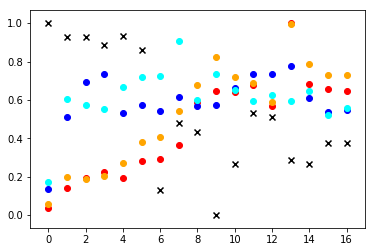

In [19]:
plt.scatter(range(17), get_min_max(total_milpers/TAI)[1][1:-5],color='red')
plt.scatter(range(17), get_min_max(total_om/TAI)[1][1:-5],color='orange')
plt.scatter(range(17), get_min_max(availability)[1], color='k', marker='x')
plt.scatter(range(17), get_min_max(total_milpers)[1][1:-5],color='blue')
plt.scatter(range(17), get_min_max(total_om)[1][1:-5],color='cyan')

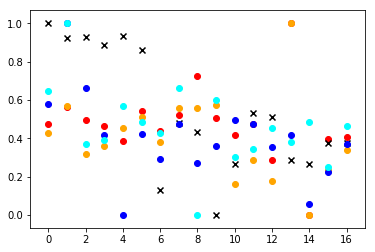

In [20]:
plt.scatter(range(17), get_min_max(get_deltas(total_milpers/TAI))[1][:-5],color='red')
plt.scatter(range(17), get_min_max(get_deltas(total_om/TAI))[1][:-5],color='orange')
plt.scatter(range(17), get_min_max(availability)[1], color='k', marker='x')
plt.scatter(range(17), get_min_max(get_deltas(total_milpers))[1][:-5],color='blue')
plt.scatter(range(17), get_min_max(get_deltas(total_om))[1][:-5],color='cyan')

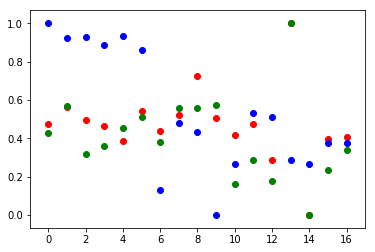

In [21]:
plt.scatter(range(17), get_min_max(get_deltas(total_milpers/TAI))[1][:-5],color='r')
plt.scatter(range(17), get_min_max(get_deltas(total_om/TAI))[1][:-5],color='g')
plt.scatter(range(17), get_min_max(availability)[1], color='b')

In [327]:
df_availability[df_availability.AFKCA=='F-15CD']

,AFKCA_TYPEID,AFKCA_TYPE,AFKCAID,AFKCA,RULE_BASE,OPS,FISCAL_YEAR,MCH,PSH,AVAILABILITY
416,21,FIGHTERS,0137,F-15CD,PER_TAI,OPS,2000,1739792,2245028,0.774953
417,21,FIGHTERS,0137,F-15CD,PER_TAI,OPS,2001,2379442,3038028,0.783219
418,21,FIGHTERS,0137,F-15CD,PER_TAI,OPS,2002,2459140,3068451,0.801427
419,21,FIGHTERS,0137,F-15CD,PER_TAI,OPS,2003,2375630,3004489,0.790694
420,21,FIGHTERS,0137,F-15CD,PER_TAI,OPS,2004,2394432,3026246,0.791222
421,21,FIGHTERS,0137,F-15CD,PER_TAI,OPS,2005,2355705,3000711,0.785049
422,21,FIGHTERS,0137,F-15CD,PER_TAI,OPS,2006,2367607,2989381,0.792006
423,21,FIGHTERS,0137,F-15CD,PER_TAI,OPS,2007,2340505,2996013,0.781207
424,21,FIGHTERS,0137,F-15CD,PER_TAI,OPS,2008,1832624,2707461,0.676879
425,21,FIGHTERS,0137,F-15CD,PER_TAI,OPS,2009,2082857,2866861,0.726529


# Models

## F-15CD

0.04359169943499235
0.0850282870843839
0.1362512732243494
0.034125190253953205
0.4543229674042706
-0.6273419881674618
-0.8767810990530593
3.5745259767827097e-31


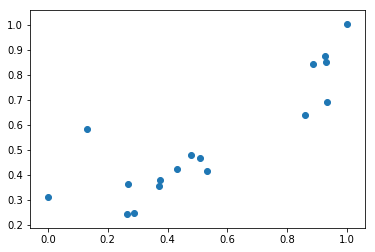

In [17]:
import numpy as np
import pandas as pd
import mysql.connector
import json
import math
import datetime
import argparse
import matplotlib.pyplot as plt
from operator import add, truediv
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from scipy.stats.stats import pearsonr




import ast
def extract_afkca(x):
    x = x.replace('{','[').replace('}',']')
    x = '{{{}}}'.format(x[1:-1])
    x = ast.literal_eval(x)['AFKCA']
    return x


def extract_budget(afkca='F-15CD', kind='MILPERS'):
    def lmap(func, alist):
        return list(map(func, alist))
    return np.array(lmap(float, df_budget[df_budget['AFKCA'] == afkca].iloc[0][kind].split(',')))

def get_min_max(seq):
    min_ = min(seq)
    seq = seq-min_
    max_ = max(seq)
    seq = seq/max_
    return [(min_,max_),seq]

def get_deltas(seq):
    deltas = [] 
    i=0
    while i < len(seq)-1:
        deltas.append(seq[i+1]-seq[i])
        i+=1
    return np.array(deltas)

TAI = extract_budget('F-15CD', kind='FORCES_TAI')


connected_ACS = df_afkca[df_afkca.AFKCA == 'F-15CD'].CONNECTED_AFKCA_ACS.iloc[0]
connected_SSS = df_afkca[df_afkca.AFKCA == 'F-15CD'].CONNECTED_AFKCA_SSS.iloc[0]
all_connections = extract_afkca(connected_ACS) + extract_afkca(connected_SSS)

total_milpers = extract_budget(afkca='F-15CD', kind='MILPERS')
for afk in all_connections:
    total_milpers = total_milpers + extract_budget(afkca=afk, kind='MILPERS')

total_om = extract_budget(afkca='F-15CD', kind='OM')
for afk in all_connections:
    total_om = total_om + extract_budget(afkca=afk, kind='OM')

all_features=[]

for i in range(17):
    
    this_row = []
    
    d_milp    = get_min_max(get_deltas(total_milpers    ))[1][:-5][i]
    d_om      = get_min_max(get_deltas(total_om         ))[1][:-5][i]
    
    d_milp_tai= get_min_max(get_deltas(total_milpers/TAI))[1][:-5][i]
    d_om_tai  = get_min_max(get_deltas(total_om/TAI     ))[1][:-5][i]
    
    milp      = get_min_max(total_milpers    )[1][1:-5][i]
    om        = get_min_max(total_om         )[1][1:-5][i]
    
    milp_tai  = get_min_max(total_milpers/TAI)[1][1:-5][i]
    om_tai    = get_min_max(total_om/TAI     )[1][1:-5][1]
    
    for feat in (d_milp,d_om,d_milp_tai,d_om_tai,milp,om,milp_tai,om_tai):
        this_row.append(feat)
    
    all_features.append(this_row)
    

availability=np.array(list(df_availability[df_availability.AFKCA=='F-15CD'].AVAILABILITY)[2:])    

model=RidgeCV()
model.fit(all_features,get_min_max(availability)[1])
pred_avail = model.predict(all_features)
plt.scatter(get_min_max(availability)[1],pred_avail)
for coef in model.coef_:
    print(coef)

## F-16CD

-0.12032318316014073
-0.09182783373974857
0.18399109531842597
0.15708159675950945
0.6487231246174324
0.14952335581209097
-1.0485745912392979
0.0


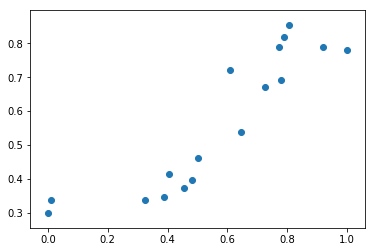

In [11]:
TAI = extract_budget('F-16CD', kind='FORCES_TAI')


connected_ACS = df_afkca[df_afkca.AFKCA == 'F-16CD'].CONNECTED_AFKCA_ACS.iloc[0]
connected_SSS = df_afkca[df_afkca.AFKCA == 'F-16CD'].CONNECTED_AFKCA_SSS.iloc[0]
all_connections = extract_afkca(connected_ACS) + extract_afkca(connected_SSS)

total_milpers = extract_budget(afkca='F-16CD', kind='MILPERS')
for afk in all_connections:
    total_milpers = total_milpers + extract_budget(afkca=afk, kind='MILPERS')

total_om = extract_budget(afkca='F-16CD', kind='OM')
for afk in all_connections:
    total_om = total_om + extract_budget(afkca=afk, kind='OM')

all_features=[]

for i in range(17):
    
    this_row = []
    
    d_milp    = get_min_max(get_deltas(total_milpers    ))[1][:-5][i]
    d_om      = get_min_max(get_deltas(total_om         ))[1][:-5][i]
    
    d_milp_tai= get_min_max(get_deltas(total_milpers/TAI))[1][:-5][i]
    d_om_tai  = get_min_max(get_deltas(total_om/TAI     ))[1][:-5][i]
    
    milp      = get_min_max(total_milpers    )[1][1:-5][i]
    om        = get_min_max(total_om         )[1][1:-5][i]
    
    milp_tai  = get_min_max(total_milpers/TAI)[1][1:-5][i]
    om_tai    = get_min_max(total_om/TAI     )[1][1:-5][1]
    
    for feat in (d_milp,d_om,d_milp_tai,d_om_tai,milp,om,milp_tai,om_tai):
        this_row.append(feat)
    
    all_features.append(this_row)

availability=np.array(list(df_availability[df_availability.AFKCA=='F-16CD'].AVAILABILITY)[2:])    

model=RidgeCV()
model.fit(all_features,get_min_max(availability)[1])
pred_avail = model.predict(all_features)
plt.scatter(get_min_max(availability)[1],pred_avail)
for coef in model.coef_:
    print(coef)

## F-15E

0.023706075266592394
0.019495001957805402
0.019160943205012798
0.016680891634216898
-0.0019143398609216332
-0.011741635608351354
-0.0020404976438901288
0.0


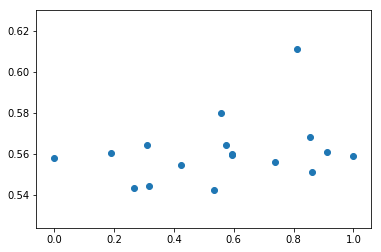

In [12]:
TAI = extract_budget('F-15E', kind='FORCES_TAI')


connected_ACS = df_afkca[df_afkca.AFKCA == 'F-15E'].CONNECTED_AFKCA_ACS.iloc[0]
connected_SSS = df_afkca[df_afkca.AFKCA == 'F-15E'].CONNECTED_AFKCA_SSS.iloc[0]
all_connections = extract_afkca(connected_ACS) + extract_afkca(connected_SSS)

total_milpers = extract_budget(afkca='F-15E', kind='MILPERS')
for afk in all_connections:
    total_milpers = total_milpers + extract_budget(afkca=afk, kind='MILPERS')

total_om = extract_budget(afkca='F-15E', kind='OM')
for afk in all_connections:
    total_om = total_om + extract_budget(afkca=afk, kind='OM')

all_features=[]

for i in range(17):
    
    this_row = []
    
    d_milp    = get_min_max(get_deltas(total_milpers    ))[1][:-5][i]
    d_om      = get_min_max(get_deltas(total_om         ))[1][:-5][i]
    
    d_milp_tai= get_min_max(get_deltas(total_milpers/TAI))[1][:-5][i]
    d_om_tai  = get_min_max(get_deltas(total_om/TAI     ))[1][:-5][i]
    
    milp      = get_min_max(total_milpers    )[1][1:-5][i]
    om        = get_min_max(total_om         )[1][1:-5][i]
    
    milp_tai  = get_min_max(total_milpers/TAI)[1][1:-5][i]
    om_tai    = get_min_max(total_om/TAI     )[1][1:-5][1]
    
    for feat in (d_milp,d_om,d_milp_tai,d_om_tai,milp,om,milp_tai,om_tai):
        this_row.append(feat)
    
    all_features.append(this_row)
    
availability=np.array(list(df_availability[df_availability.AFKCA=='F-15E'].AVAILABILITY)[2:])    

model=RidgeCV()
model.fit(all_features,get_min_max(availability)[1])
pred_avail = model.predict(all_features)
plt.scatter(get_min_max(availability)[1],pred_avail)
for coef in model.coef_:
    print(coef)

# validation

In [431]:
def list_rotN(test_list,N):
    
    return test_list[N:] + test_list[:N]

array([ 4.35916994e-02,  8.50282871e-02,  1.36251273e-01,  3.41251903e-02,
        4.54322967e-01, -6.27341988e-01, -8.76781099e-01,  3.57452598e-31])

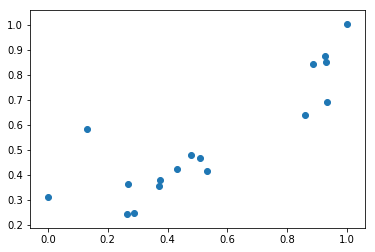

In [13]:
TAI = extract_budget('F-15CD', kind='FORCES_TAI')


connected_ACS = df_afkca[df_afkca.AFKCA == 'F-15CD'].CONNECTED_AFKCA_ACS.iloc[0]
connected_SSS = df_afkca[df_afkca.AFKCA == 'F-15CD'].CONNECTED_AFKCA_SSS.iloc[0]
all_connections = extract_afkca(connected_ACS) + extract_afkca(connected_SSS)

total_milpers = extract_budget(afkca='F-15CD', kind='MILPERS')
for afk in all_connections:
    total_milpers = total_milpers + extract_budget(afkca=afk, kind='MILPERS')

total_om = extract_budget(afkca='F-15CD', kind='OM')
for afk in all_connections:
    total_om = total_om + extract_budget(afkca=afk, kind='OM')

all_features=[]

for i in range(17):
    
    this_row = []
    
    d_milp    = get_min_max(get_deltas(total_milpers    ))[1][:-5][i]
    d_om      = get_min_max(get_deltas(total_om         ))[1][:-5][i]
    
    d_milp_tai= get_min_max(get_deltas(total_milpers/TAI))[1][:-5][i]
    d_om_tai  = get_min_max(get_deltas(total_om/TAI     ))[1][:-5][i]
    
    milp      = get_min_max(total_milpers    )[1][1:-5][i]
    om        = get_min_max(total_om         )[1][1:-5][i]
    
    milp_tai  = get_min_max(total_milpers/TAI)[1][1:-5][i]
    om_tai    = get_min_max(total_om/TAI     )[1][1:-5][1]
    
    for feat in (d_milp,d_om,d_milp_tai,d_om_tai,milp,om,milp_tai,om_tai):
        this_row.append(feat)
    
    all_features.append(this_row)

availability=np.array(list(df_availability[df_availability.AFKCA=='F-15CD'].AVAILABILITY)[2:])    

model=RidgeCV()
model.fit(all_features,get_min_max(availability)[1])
pred_avail = model.predict(all_features)
plt.scatter(get_min_max(availability)[1],pred_avail)
model.coef_




N=0 [ 4.35916994e-02  8.50282871e-02  1.36251273e-01  3.41251903e-02
  4.54322967e-01 -6.27341988e-01 -8.76781099e-01  3.57452598e-31]
N=1 [ 1.51123507e-01  1.95579803e-01 -7.57258699e-02 -8.83544262e-02
 -3.52236758e-02 -1.91794346e-01 -2.69467834e-01 -7.08742220e-32]
N=2 [ 2.58078810e-01 -3.53074330e-03 -1.31620783e-02 -1.04622152e-01
 -1.10181279e-01 -3.03918977e-01 -9.00353048e-02 -2.03378202e-31]
N=3 [ 8.68369396e-02  1.23954782e-01 -1.32166603e-01 -9.32041461e-02
 -2.02674856e-01 -2.29706754e-01  5.85117410e-02 -3.17393255e-31]
N=4 [-1.14880320e-01  5.41286761e-01 -1.00217634e-01  1.88909737e-01
 -4.25031421e-01 -8.57711441e-01  6.49007385e-01  1.35585468e-31]
N=5 [-1.59672182e-02 -1.52825433e-02 -1.72930070e-02 -2.19268428e-02
 -2.95950220e-03 -2.71755459e-02  5.11518585e-02 -1.00148357e-32]
N=6 [ 6.95925914e-02  2.79004681e-01 -1.80523538e-01 -2.10323109e-01
  2.24425038e-01 -2.21155678e-01  8.79563947e-01 -8.62816615e-32]
N=7 [-7.83293034e-02 -3.02971034e-03 -7.45967519e-02 -1

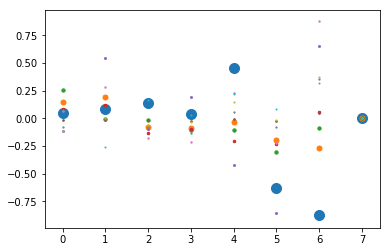

In [14]:
def list_rotN(test_list,N):
    
    return test_list[N:] + test_list[:N]

for N in range(10):
    
    availability=np.array( list_rotN(list(df_availability[df_availability.AFKCA=='F-15CD'].AVAILABILITY)[2:],N))

    
    model=RidgeCV()
    model.fit(all_features,get_min_max(availability)[1])
    pred_avail = model.predict(all_features)
    plt.scatter(range(8),model.coef_,s=100/(N+1)**2)
    print('N={}'.format(N),model.coef_)

array([-0.12032318, -0.09182783,  0.1839911 ,  0.1570816 ,  0.64872312,
        0.14952336, -1.04857459,  0.        ])

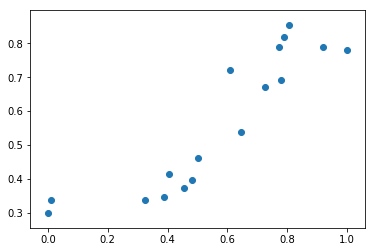

In [15]:
TAI = extract_budget('F-16CD', kind='FORCES_TAI')


connected_ACS = df_afkca[df_afkca.AFKCA == 'F-16CD'].CONNECTED_AFKCA_ACS.iloc[0]
connected_SSS = df_afkca[df_afkca.AFKCA == 'F-16CD'].CONNECTED_AFKCA_SSS.iloc[0]
all_connections = extract_afkca(connected_ACS) + extract_afkca(connected_SSS)

total_milpers = extract_budget(afkca='F-16CD', kind='MILPERS')
for afk in all_connections:
    total_milpers = total_milpers + extract_budget(afkca=afk, kind='MILPERS')

total_om = extract_budget(afkca='F-16CD', kind='OM')
for afk in all_connections:
    total_om = total_om + extract_budget(afkca=afk, kind='OM')

all_features=[]

for i in range(17):
    
    this_row = []
    
    d_milp    = get_min_max(get_deltas(total_milpers    ))[1][:-5][i]
    d_om      = get_min_max(get_deltas(total_om         ))[1][:-5][i]
    
    d_milp_tai= get_min_max(get_deltas(total_milpers/TAI))[1][:-5][i]
    d_om_tai  = get_min_max(get_deltas(total_om/TAI     ))[1][:-5][i]
    
    milp      = get_min_max(total_milpers    )[1][1:-5][i]
    om        = get_min_max(total_om         )[1][1:-5][i]
    
    milp_tai  = get_min_max(total_milpers/TAI)[1][1:-5][i]
    om_tai    = get_min_max(total_om/TAI     )[1][1:-5][1]
    
    for feat in (d_milp,d_om,d_milp_tai,d_om_tai,milp,om,milp_tai,om_tai):
        this_row.append(feat)
    
    all_features.append(this_row)
    

availability=np.array(list(df_availability[df_availability.AFKCA=='F-16CD'].AVAILABILITY)[2:])    

model=RidgeCV()
model.fit(all_features,get_min_max(availability)[1])
pred_avail = model.predict(all_features)
plt.scatter(get_min_max(availability)[1],pred_avail)
model.coef_




N=0 [-0.12032318 -0.09182783  0.1839911   0.1570816   0.64872312  0.14952336
 -1.04857459  0.        ]
N=1 [ 0.13345194 -0.03938259  0.24772955 -0.0397928   0.3920047   0.06374904
 -0.90693334  0.        ]
N=2 [ 0.16105653  0.06204975  0.07338012 -0.02297791 -0.10026508  0.00692979
 -0.34085509  0.        ]
N=3 [ 0.0562315   0.07637093 -0.03979207  0.02908108 -0.21050359 -0.08937132
 -0.32219225  0.        ]
N=4 [ 0.04089196  0.10081993 -0.08989484  0.00539264 -0.16460347 -0.12065829
 -0.17621243  0.        ]
N=5 [-0.00494105  0.02205183 -0.0284508   0.00548283 -0.01794589 -0.02206327
 -0.00952461  0.        ]
N=6 [-0.00813865  0.01252426 -0.02539957 -0.00030441 -0.00412085 -0.02903845
  0.01354318  0.        ]
N=7 [ 0.09415256  0.13167016 -0.100149   -0.07673216  0.06682372 -0.21897775
  0.21076431  0.        ]
N=8 [ 0.32366488  0.64294955 -0.43739567 -0.22079692  0.20420522 -0.69437677
  0.68537128  0.        ]
N=9 [-0.06950756  0.05358927  0.04849542  0.13421551  0.19083481 -0.89991

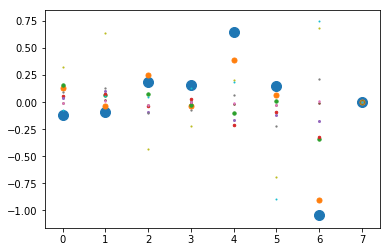

In [16]:
def list_rotN(test_list,N):
    
    return test_list[N:] + test_list[:N]

for N in range(10):
    
    availability=np.array( list_rotN(list(df_availability[df_availability.AFKCA=='F-16CD'].AVAILABILITY)[2:],N))

    
    model=RidgeCV()
    model.fit(all_features,get_min_max(availability)[1])
    pred_avail = model.predict(all_features)
    plt.scatter(range(8),model.coef_,s=100/(N+1)**2)
    print('N={}'.format(N),model.coef_)

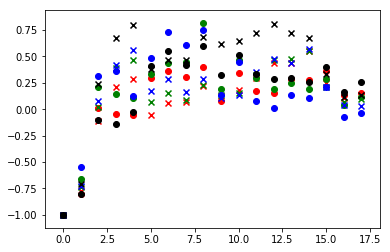

In [387]:
total_milpers = extract_budget(afkca='F-15E', kind='MILPERS')
for afk in all_connections:
    total_milpers = total_milpers + extract_budget(afkca=afk, kind='MILPERS')
plt.scatter(range(18), get_min_max(total_milpers)[1][:-5],color='r',marker='x')

total_om = extract_budget(afkca='F-15E', kind='OM')
for afk in all_connections:
    total_om = total_om + extract_budget(afkca=afk, kind='OM')
plt.scatter(range(18), get_min_max(total_om)[1][:-5],color='r',marker='o')

total_milpers = extract_budget(afkca='F-15CD', kind='MILPERS')
for afk in all_connections:
    total_milpers = total_milpers + extract_budget(afkca=afk, kind='MILPERS')
plt.scatter(range(18), get_min_max(total_milpers)[1][:-5],color='g',marker='x')

total_om = extract_budget(afkca='F-15CD', kind='OM')
for afk in all_connections:
    total_om = total_om + extract_budget(afkca=afk, kind='OM')
plt.scatter(range(18), get_min_max(total_om)[1][:-5],color='g',marker='o')

total_milpers = extract_budget(afkca='F-16CD', kind='MILPERS')
for afk in all_connections:
    total_milpers = total_milpers + extract_budget(afkca=afk, kind='MILPERS')
plt.scatter(range(18), get_min_max(total_milpers)[1][:-5],color='b',marker='x')

total_om = extract_budget(afkca='F-16CD', kind='OM')
for afk in all_connections:
    total_om = total_om + extract_budget(afkca=afk, kind='OM')
plt.scatter(range(18), get_min_max(total_om)[1][:-5],color='b',marker='o')


total_milpers = extract_budget(afkca='C-130H', kind='MILPERS')
for afk in all_connections:
    total_milpers = total_milpers + extract_budget(afkca=afk, kind='MILPERS')
plt.scatter(range(18), get_min_max(total_milpers)[1][:-5],color='k',marker='x')

total_om = extract_budget(afkca='C-130H', kind='OM')
for afk in all_connections:
    total_om = total_om + extract_budget(afkca=afk, kind='OM')
plt.scatter(range(18), get_min_max(total_om)[1][:-5],color='k',marker='o')